In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
df = pd.read_csv("final_policy.csv")
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,643,3,unknown,yes
45207,70,retired,divorced,primary,cellular,17,nov,456,2,unknown,yes
45208,70,retired,married,secondary,cellular,17,nov,643,5,success,yes
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,no


# Correlation Matrix

<Axes: >

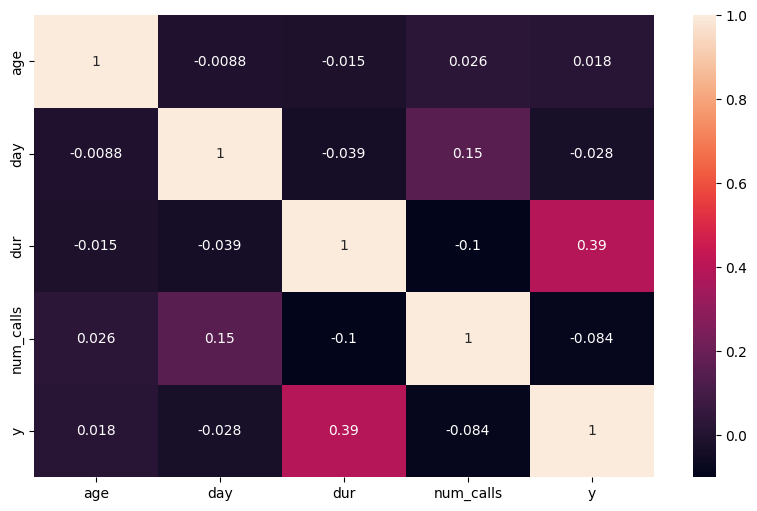

In [11]:
df.replace({'y' : { 'yes' : 1, 'no' : 0}},inplace=True)
num_df = df[["age" , "day" , "dur" , "num_calls" , "y"]]
import seaborn as sn
plt.figure(figsize = (10,6))
sn.heatmap(num_df.corr(), annot=True)

**Observation - No features exhibit both high positive and high negative correlation; if such correlations were present (e.g., above 0.8 or below -0.8), dropping redundant features could streamline the model and mitigate multicollinearity concerns.**

# One Hot Encoding

In [12]:
cat_var= df.select_dtypes(include= ["object"]).columns
print(cat_var)

Index(['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome'], dtype='object')


In [13]:
for i in cat_var:
    print(i, ":", df[i].unique())
    print()

job : ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

marital : ['married' 'single' 'divorced']

education_qual : ['tertiary' 'secondary' 'unknown' 'primary']

call_type : ['unknown' 'cellular' 'telephone']

mon : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

prev_outcome : ['unknown' 'failure' 'other' 'success']



In [14]:
def encoding_data(df,col):
  for i in col:
     df_dummies = pd.get_dummies(df[i], prefix=i)
     df = pd.concat([df, df_dummies], axis=1)
     df.drop([i],inplace=True,axis=1)
  return df

In [15]:
columns=['call_type','prev_outcome','marital','job']
df=encoding_data(df,columns)

In [16]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['mon'] = df['mon'].apply(
    lambda x: months.index(x)+1
)

In [17]:
df.replace({'education_qual' : { 'unknown' : 0, 'tertiary' : 1, 'secondary' : 2, 'primary' : 3 }},inplace=True)

In [18]:
df

,age,education_qual,day,mon,dur,num_calls,y,call_type_cellular,call_type_telephone,call_type_unknown,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,1,5,5,261,1,0,False,False,True,...,False,False,True,False,False,False,False,False,False,False
1,44,2,5,5,151,1,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,33,2,5,5,76,1,0,False,False,True,...,True,False,False,False,False,False,False,False,False,False
3,47,0,5,5,92,1,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,33,0,5,5,198,1,0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,1,17,11,643,3,1,True,False,False,...,False,False,False,False,False,False,False,True,False,False
45207,70,3,17,11,456,2,1,True,False,False,...,False,False,False,True,False,False,False,False,False,False
45208,70,2,17,11,643,5,1,True,False,False,...,False,False,False,True,False,False,False,False,False,False
45209,57,2,17,11,508,4,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False


## Splitting of Dataset

In [19]:
p= df.drop(['y'],axis=1)
q= df['y']

# Resampling of Dataset

**Since the class distribution in the target variable is ~89:11 indicating an imbalance dataset, we need to resample it.**

In [20]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy=0.75)
X, y = adasyn.fit_resample(p, q)
print(y.value_counts())

y
0    39922
1    30486
Name: count, dtype: int64


## Train - Test Split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

## Scalling

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models

## Logistic Regression

In [17]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning

# Define logistic regression parameters
logistic_regression_params = {
    'C': [1, 5, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [200, 500, 1000]  # Increased max_iter values
}

# Function to manually perform hyperparameter tuning for logistic regression
def tune_logistic_regression(params):
    best_score = 0
    best_params = {}
    keys, values = zip(*params.items())
    
    for v in itertools.product(*values):
        param_dict = dict(zip(keys, v))
        model = LogisticRegression(**param_dict)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
        
        if score > best_score:
            best_score = score
            best_params = param_dict
    
    return best_score, best_params

# Perform tuning for logistic regression
best_score, best_params = tune_logistic_regression(logistic_regression_params)

# Print the best accuracy score and the corresponding parameter values
print(f"Best Accuracy Score: {best_score}")
print(f"Best Parameters: {best_params}")


Best Accuracy Score: 0.9216020451640392
Best Parameters: {'C': 10, 'solver': 'liblinear', 'max_iter': 200}


## Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning

rf_params = {
    'n_estimators': [1, 5, 10, 20]
}

def tune_rf(params):
    best_score = 0
    best_params = {}
    keys, values = zip(*params.items())
    
    for v in itertools.product(*values):
        param_dict = dict(zip(keys, v))
        model = RandomForestClassifier(**param_dict)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
        
        if score > best_score:
            best_score = score
            best_params = param_dict
    
    return best_score, best_params

best_score, best_params = tune_rf(rf_params)

print(f"Best Accuracy Score: {best_score}")
print(f"Best Parameters: {best_params}")


Best Accuracy Score: 0.9363726743360318
Best Parameters: {'n_estimators': 20}


## Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning

dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15]
}

def tune_dt(params):
    best_score = 0
    best_params = {}
    keys, values = zip(*params.items())
    
    for v in itertools.product(*values):
        param_dict = dict(zip(keys, v))
        model = DecisionTreeClassifier(**param_dict)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
        
        if score > best_score:
            best_score = score
            best_params = param_dict
    
    return best_score, best_params

best_score, best_params = tune_rf(dt_params)

print(f"Best Accuracy Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Accuracy Score: 0.9381479903422809
Best Parameters: {'criterion': 'gini', 'max_depth': None}


## Support Vector Machine (SVM)

In [23]:
from sklearn import svm
from sklearn.metrics import accuracy_score
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
best_score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {best_score}")

Accuracy Score: 0.9153001936733376


## K-Nearest Neighbors (KNN)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

def tune_knn(params):
    best_score = 0
    best_params = {}
    keys, values = zip(*params.items())
    
    for v in itertools.product(*values):
        param_dict = dict(zip(keys, v))
        model = KNeighborsClassifier(**param_dict)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
        
        if score > best_score:
            best_score = score
            best_params = param_dict
    
    return best_score, best_params

best_score, best_params = tune_knn(knn_params)

print(f"Best Accuracy Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Accuracy Score: 0.9307510221648375
Best Parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}


## Naive Bayes (GaussianNB)

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
best_score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {best_score}")

Accuracy Score: 0.8083925112976114


## Gradient Boosting

In [30]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning

xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

def tune_xgb(params):
    best_score = 0
    best_params = {}
    keys, values = zip(*params.items())
    
    for v in itertools.product(*values):
        param_dict = dict(zip(keys, v))
        model = xgb.XGBClassifier(**param_dict, use_label_encoder=False, eval_metric='logloss')
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
        
        if score > best_score:
            best_score = score
            best_params = param_dict
    
    return best_score, best_params

best_score, best_params = tune_xgb(xgb_params)

print(f"Best Accuracy Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Accuracy Score: 0.9371637615666021
Best Parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}


**Given the minimal difference in accuracy scores among the Random Forest Classifier, Decision Tree, KNN, and Gradient Boosting models with their optimized parameters, further evaluation is necessary to determine the best model.**

## Cross Validation

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = {
    'Random Forest Classifier': RandomForestClassifier(n_estimators=20),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=None),
    'KNN': KNeighborsClassifier(n_neighbors=9, weights='distance', p=1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8)
}

for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    print(f"{model_name} - Mean Accuracy: {scores.mean()}, Std Dev: {scores.std()}")

Random Forest Classifier - Mean Accuracy: 0.835856180439891, Std Dev: 0.11458943176048544
Decision Tree - Mean Accuracy: 0.7684903559992768, Std Dev: 0.0959984432600419
KNN - Mean Accuracy: 0.81348601454468, Std Dev: 0.05638532218738861
Gradient Boosting - Mean Accuracy: 0.7729927248357026, Std Dev: 0.11850736610182583


## AUC Score

In [33]:
from sklearn.metrics import roc_auc_score

random_forest = RandomForestClassifier(n_estimators=20, random_state=42)
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
knn = KNeighborsClassifier(n_neighbors=9, weights='distance', p=1)
gradient_boosting = GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, random_state=42)

random_forest.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
knn.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

random_forest_probs = random_forest.predict_proba(X_test)[:, 1]
decision_tree_probs = decision_tree.predict_proba(X_test)[:, 1]
knn_probs = knn.predict_proba(X_test)[:, 1]
gradient_boosting_probs = gradient_boosting.predict_proba(X_test)[:, 1]

random_forest_auc = roc_auc_score(y_test, random_forest_probs)
decision_tree_auc = roc_auc_score(y_test, decision_tree_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
gradient_boosting_auc = roc_auc_score(y_test, gradient_boosting_probs)

print("Random Forest AUC:", random_forest_auc)
print("Decision Tree AUC:", decision_tree_auc)
print("KNN AUC:", knn_auc)
print("Gradient Boosting AUC:", gradient_boosting_auc)

Random Forest AUC: 0.9831834770890706
Decision Tree AUC: 0.9089180220679419
KNN AUC: 0.9755458410780322
Gradient Boosting AUC: 0.9856676206918306


**The Gradient Boosting model, with a ROC AUC score of 0.986 and a mean accuracy of 0.773 (±0.119), stands out as the best performer, demonstrating superior discrimination ability and consistent performance across the provided dataset.**

## Features Importance

In [37]:
gradient_boosting.fit(X_train, y_train)
feature_importances = gradient_boosting.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Important Features:")
print(feature_importance_df)

Important Features:
                 Feature  Importance
4                    dur    0.278727
12  prev_outcome_unknown    0.150684
9   prev_outcome_failure    0.103229
3                    mon    0.070860
10    prev_outcome_other    0.057876
8      call_type_unknown    0.043599
2                    day    0.043346
0                    age    0.042696
13      marital_divorced    0.026297
1         education_qual    0.021311
20        job_management    0.019058
17       job_blue-collar    0.016817
15        marital_single    0.016270
14       marital_married    0.016026
5              num_calls    0.014571
25        job_technician    0.014348
16            job_admin.    0.008836
11  prev_outcome_success    0.008732
23          job_services    0.008360
6     call_type_cellular    0.008276
7    call_type_telephone    0.007292
18      job_entrepreneur    0.005291
22     job_self-employed    0.004901
21           job_retired    0.003560
26        job_unemployed    0.003341
19         job_hou

**Most important feature is Duration.**
**

# Conclusion

**After assessing seven different models (Logistic Regression, Support Vector Machine, Naive Bayes, Random Forest Classifier, Decision Tree, KNN and Gradient Boosting) to predict client subscriptions, the Gradient Boosting model stood out. With a high ROC AUC score of 0.986 and an average accuracy of 0.773 (plus or minus 0.119), it showed excellent prediction ability across various data sets.**

**This suggests that the Gradient Boosting model is a great choice for predicting if a client will subscribe to insurance. Using this model in real-world scenarios can help target potential customers accurately and save on marketing expenses.**